# Training a Neural Network with cuDNN

This notebook demonstrates training a simple MLP on the California Housing dataset using cuDNN primitives directly.

**Note**: cuDNN is a low-level library - it provides optimized primitives but NOT:
- Automatic differentiation
- Optimizers
- Loss functions

We must manually:
1. Define forward pass graphs
2. Define backward pass graphs (gradient computation)
3. Implement weight updates (SGD)

In [1]:
import cudnn
import torch
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print(f"cuDNN frontend: {cudnn.__version__}")
print(f"cuDNN backend: {cudnn.backend_version()}")
torch.manual_seed(42)


cuDNN frontend: 1.14.1
cuDNN backend: 91301


## Load California Housing Dataset


In [2]:
# Load dataset from CSV
df = pd.read_csv("data/housing.csv")
print(f"Dataset shape (raw): {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Drop rows with missing values (total_bedrooms has ~207 NaN)
df = df.dropna()
print(f"Dataset shape (clean): {df.shape}")
df.head()


Dataset shape (raw): (20640, 10)
Missing values: 207
Dataset shape (clean): (20433, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Prepare data using loaded DataFrame
X = df.drop(columns=["median_house_value", "ocean_proximity"]).values
y = df["median_house_value"].values.reshape(-1, 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features (critical for NN training)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Features: {df.drop(columns=['median_house_value', 'ocean_proximity']).columns.tolist()}")


Train: (16346, 8), Test: (4087, 8)
Features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [4]:
# Convert to GPU tensors (use float32 for stability, cuDNN will use tensor cores where applicable)
BATCH_SIZE = 256
N_FEATURES = 8
HIDDEN_DIM = 64
OUTPUT_DIM = 1

# Full dataset tensors for final eval
X_train_gpu = torch.tensor(X_train, dtype=torch.float32, device="cuda")
y_train_gpu = torch.tensor(y_train, dtype=torch.float32, device="cuda")
X_test_gpu = torch.tensor(X_test, dtype=torch.float32, device="cuda")
y_test_gpu = torch.tensor(y_test, dtype=torch.float32, device="cuda")

print(f"X_train_gpu: {X_train_gpu.shape}, y_train_gpu: {y_train_gpu.shape}")


X_train_gpu: torch.Size([16346, 8]), y_train_gpu: torch.Size([16346, 1])


## Initialize Weights

MLP Architecture: Input(8) → Dense(64) → ReLU → Dense(1)

Using Kaiming initialization for ReLU networks.


In [5]:
# Initialize weights with Kaiming initialization
import math

def kaiming_init(fan_in, fan_out):
    std = math.sqrt(2.0 / fan_in)
    return torch.randn(fan_in, fan_out, device="cuda", dtype=torch.float32) * std

# Layer 1: (8 -> 64)
W1 = kaiming_init(N_FEATURES, HIDDEN_DIM)
b1 = torch.zeros(1, HIDDEN_DIM, device="cuda", dtype=torch.float32)

# Layer 2: (64 -> 1)
W2 = kaiming_init(HIDDEN_DIM, OUTPUT_DIM)
b2 = torch.zeros(1, OUTPUT_DIM, device="cuda", dtype=torch.float32)

print(f"W1: {W1.shape}, b1: {b1.shape}")
print(f"W2: {W2.shape}, b2: {b2.shape}")


W1: torch.Size([8, 64]), b1: torch.Size([1, 64])
W2: torch.Size([64, 1]), b2: torch.Size([1, 1])


## Create cuDNN Graphs for Forward & Backward Pass

We create cuDNN matmul graphs for the compute-heavy operations. Pointwise ops (ReLU, bias add) use PyTorch since they're memory-bound anyway.

For training, we need:
- **Forward**: $h = XW + b$, $a = \text{ReLU}(h)$
- **Backward**: $\frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial h}$


In [6]:
handle = cudnn.create_handle()

# Minimum dimensions for cuDNN matmul (engines don't support tiny matrices)
MIN_DIM = 32

class CudnnMatmul:
    """Wrapper for cuDNN matmul that caches built graphs. Falls back to PyTorch for small dims."""
    
    def __init__(self, handle):
        self.handle = handle
        self.cache = {}
        self.fallback_count = 0
        self.cudnn_count = 0
    
    def _can_use_cudnn(self, M, K, N):
        """Check if dimensions are large enough for cuDNN."""
        return M >= MIN_DIM and K >= MIN_DIM and N >= MIN_DIM
    
    def _get_graph(self, M, K, N):
        """Get or create a cuDNN graph for matmul [M,K] @ [K,N] = [M,N]"""
        key = (M, K, N)
        if key not in self.cache:
            graph = cudnn.pygraph(
                handle=self.handle,
                io_data_type=cudnn.data_type.FLOAT,
                compute_data_type=cudnn.data_type.FLOAT,
            )
            
            A = graph.tensor(name="A", dim=[M, K], stride=[K, 1], data_type=cudnn.data_type.FLOAT)
            B = graph.tensor(name="B", dim=[K, N], stride=[N, 1], data_type=cudnn.data_type.FLOAT)
            C = graph.matmul(A, B, compute_data_type=cudnn.data_type.FLOAT)
            C.set_output(True)
            
            try:
                graph.build([cudnn.heur_mode.A])
            except Exception as e:
                # Mark as unsupported
                self.cache[key] = None
                return None
            
            workspace = torch.empty(graph.get_workspace_size(), device="cuda", dtype=torch.uint8)
            
            # Get UIDs
            A_uid = A.get_uid()
            B_uid = B.get_uid()
            C_uid = C.get_uid()
            
            self.cache[key] = (graph, workspace, A_uid, B_uid, C_uid)
        
        return self.cache[key]
    
    def forward(self, A_gpu, B_gpu):
        """Compute A @ B using cuDNN if possible, else PyTorch."""
        M, K = A_gpu.shape
        K2, N = B_gpu.shape
        assert K == K2, f"Dimension mismatch: {K} vs {K2}"
        
        # Try cuDNN for large enough matrices
        if self._can_use_cudnn(M, K, N):
            result = self._get_graph(M, K, N)
            if result is not None:
                graph, workspace, A_uid, B_uid, C_uid = result
                C_gpu = torch.empty(M, N, device="cuda", dtype=torch.float32)
                graph.execute({A_uid: A_gpu, B_uid: B_gpu, C_uid: C_gpu}, workspace, handle=self.handle)
                self.cudnn_count += 1
                return C_gpu
        
        # Fallback to PyTorch
        self.fallback_count += 1
        return torch.mm(A_gpu, B_gpu)

matmul = CudnnMatmul(handle)
print("cuDNN matmul wrapper created (with PyTorch fallback for small dims)")


cuDNN matmul wrapper created (with PyTorch fallback for small dims)


In [7]:
def forward(X, W1, b1, W2, b2):
    """
    Forward pass: X -> Linear -> ReLU -> Linear -> output
    Returns output and cached activations for backward pass.
    """
    # Layer 1: h1 = X @ W1 + b1
    h1 = matmul.forward(X, W1) + b1
    
    # ReLU activation
    a1 = torch.relu(h1)
    
    # Layer 2: y_pred = a1 @ W2 + b2
    y_pred = matmul.forward(a1, W2) + b2
    
    # Cache for backward pass
    cache = (X, h1, a1, W1, W2)
    return y_pred, cache


def backward(y_pred, y_true, cache):
    """
    Backward pass: compute gradients for W1, b1, W2, b2.
    
    Loss: MSE = mean((y_pred - y_true)^2)

    CUDNN defines convfwd and convbwd operations, as these are different mathematical operations.
    Matrix weight updating are performed using matmul, and so are the same mathematical operation that uses the same graph (operations & execution).
    Hence we use matmul.forward() for the weight update.
    """
    X, h1, a1, W1, W2 = cache
    batch_size = X.shape[0]
    
    # Gradient of MSE loss: dL/dy_pred = 2 * (y_pred - y_true) / batch_size
    dy_pred = 2.0 * (y_pred - y_true) / batch_size
    
    # Layer 2 gradients
    # dL/dW2 = a1.T @ dy_pred
    dW2 = matmul.forward(a1.T.contiguous(), dy_pred)
    # dL/db2 = sum(dy_pred, dim=0)
    db2 = dy_pred.sum(dim=0, keepdim=True)
    # dL/da1 = dy_pred @ W2.T
    da1 = matmul.forward(dy_pred, W2.T.contiguous())
    
    # ReLU backward: dL/dh1 = dL/da1 * (h1 > 0)
    dh1 = da1 * (h1 > 0).float()
    
    # Layer 1 gradients
    # dL/dW1 = X.T @ dh1
    dW1 = matmul.forward(X.T.contiguous(), dh1)
    # dL/db1 = sum(dh1, dim=0)
    db1 = dh1.sum(dim=0, keepdim=True)
    
    return dW1, db1, dW2, db2


def mse_loss(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean()

print("Forward and backward functions defined")


Forward and backward functions defined


## Training Loop

Using SGD with momentum and L2 regularization (weight decay).


In [8]:
# Training hyperparameters
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4  # L2 regularization
N_EPOCHS = 1000

# Initialize momentum buffers
v_W1 = torch.zeros_like(W1)
v_b1 = torch.zeros_like(b1)
v_W2 = torch.zeros_like(W2)
v_b2 = torch.zeros_like(b2)

# Training history
train_losses = []
test_losses = []

n_samples = X_train_gpu.shape[0]
n_batches = (n_samples + BATCH_SIZE - 1) // BATCH_SIZE

print(f"Training: {N_EPOCHS} epochs, batch_size={BATCH_SIZE}, lr={LEARNING_RATE}")


Training: 1000 epochs, batch_size=256, lr=0.001


In [9]:
import time

start_time = time.time()

for epoch in range(N_EPOCHS):
    # Shuffle training data
    perm = torch.randperm(n_samples, device="cuda")
    X_shuffled = X_train_gpu[perm]
    y_shuffled = y_train_gpu[perm]
    
    epoch_loss = 0.0
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min(start_idx + BATCH_SIZE, n_samples)
        
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]
        
        # Forward pass
        y_pred, cache = forward(X_batch, W1, b1, W2, b2)
        loss = mse_loss(y_pred, y_batch)
        epoch_loss += loss.item()
        
        # Backward pass
        dW1, db1, dW2, db2 = backward(y_pred, y_batch, cache)
        
        # Add L2 regularization gradients
        dW1 = dW1 + WEIGHT_DECAY * W1
        dW2 = dW2 + WEIGHT_DECAY * W2
        
        # SGD with momentum update
        v_W1 = MOMENTUM * v_W1 + dW1
        v_b1 = MOMENTUM * v_b1 + db1
        v_W2 = MOMENTUM * v_W2 + dW2
        v_b2 = MOMENTUM * v_b2 + db2
        
        W1 = W1 - LEARNING_RATE * v_W1
        b1 = b1 - LEARNING_RATE * v_b1
        W2 = W2 - LEARNING_RATE * v_W2
        b2 = b2 - LEARNING_RATE * v_b2
    
    # Compute epoch losses
    train_loss = epoch_loss / n_batches
    
    y_test_pred, _ = forward(X_test_gpu, W1, b1, W2, b2)
    test_loss = mse_loss(y_test_pred, y_test_gpu).item()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if (epoch + 1) in list(range(10, 100, 10)) + list(range(100, 1100, 100)):
        print(f"Epoch {epoch+1:3d}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed:.2f}s")


Epoch  10: train_loss=0.3288, test_loss=0.3364
Epoch  20: train_loss=0.3058, test_loss=0.3189
Epoch  30: train_loss=0.2940, test_loss=0.3088
Epoch  40: train_loss=0.2870, test_loss=0.3025
Epoch  50: train_loss=0.2810, test_loss=0.2967
Epoch  60: train_loss=0.2766, test_loss=0.2935
Epoch  70: train_loss=0.2727, test_loss=0.2896
Epoch  80: train_loss=0.2698, test_loss=0.2877
Epoch  90: train_loss=0.2673, test_loss=0.2843
Epoch 100: train_loss=0.2657, test_loss=0.2855
Epoch 200: train_loss=0.2516, test_loss=0.2683
Epoch 300: train_loss=0.2414, test_loss=0.2577
Epoch 400: train_loss=0.2358, test_loss=0.2531
Epoch 500: train_loss=0.2319, test_loss=0.2489
Epoch 600: train_loss=0.2282, test_loss=0.2466
Epoch 700: train_loss=0.2256, test_loss=0.2440
Epoch 800: train_loss=0.2249, test_loss=0.2451
Epoch 900: train_loss=0.2219, test_loss=0.2415
Epoch 1000: train_loss=0.2198, test_loss=0.2410

Training completed in 36.59s


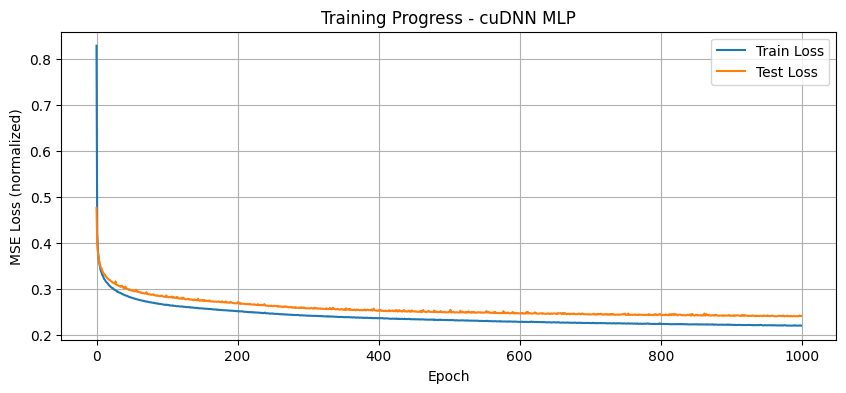

In [10]:
# Plot training curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (normalized)')
plt.title('Training Progress - cuDNN MLP')
plt.legend()
plt.grid(True)
plt.show()

## Final Inference & Results

Run inference on test set and compare predictions to actual house prices.


In [11]:
# Final inference on test set
y_pred_normalized, _ = forward(X_test_gpu, W1, b1, W2, b2)

# Convert back to original scale (undo normalization)
y_pred_np = y_pred_normalized.cpu().numpy()
y_pred_original = scaler_y.inverse_transform(y_pred_np).flatten()
y_true_original = scaler_y.inverse_transform(y_test).flatten()

# Compute RMSE in original units ($100k)
rmse = math.sqrt(((y_pred_original - y_true_original) ** 2).mean())
print(f"Test RMSE: ${rmse:,.2f}k")

# Mean Absolute Error
mae = abs(y_pred_original - y_true_original).mean()
print(f"Test MAE:  ${mae:,.2f}k")


Test RMSE: $56,483.04k
Test MAE:  $38,685.06k


In [12]:
# Create results dataframe
results_df = pd.DataFrame({
    'Actual_Price_100k': y_true_original,
    'Predicted_Price_100k': y_pred_original,
    'Error_100k': y_pred_original - y_true_original,
    'Abs_Error_100k': abs(y_pred_original - y_true_original),
})

# Add formatted dollar values
results_df['Actual_$'] = results_df['Actual_Price_100k'].apply(lambda x: f"${x*100:.1f}k")
results_df['Predicted_$'] = results_df['Predicted_Price_100k'].apply(lambda x: f"${x*100:.1f}k")
results_df['Error_$'] = results_df['Error_100k'].apply(lambda x: f"{'+' if x > 0 else ''}{x*100:.1f}k")

print("Sample predictions (first 20 test samples):")
results_df[['Actual_$', 'Predicted_$', 'Error_$']].head(20)


Sample predictions (first 20 test samples):


,Actual_$,Predicted_$,Error_$
0,$24580000.0k,$19905267.2k,-4674732.8k
1,$13790000.0k,$18587773.4k,+4797773.4k
2,$21820000.0k,$20749209.4k,-1070790.6k
3,$22080000.0k,$13069028.1k,-9010971.9k
4,$17050000.0k,$12733132.8k,-4316867.2k
5,$7500000.0k,$9234556.2k,+1734556.2k
6,$26940000.0k,$29418815.6k,+2478815.6k
7,$22890000.0k,$22514665.6k,-375334.4k
8,$50000100.0k,$45546368.8k,-4453731.2k
9,$8080000.0k,$7396237.5k,-683762.5k


Error Statistics (in $k):
  Mean Error:   -337793.80k
  Std Error:    5638883.99k
  Median Error: 2629801.56k
  Max Error:    37257489.06k


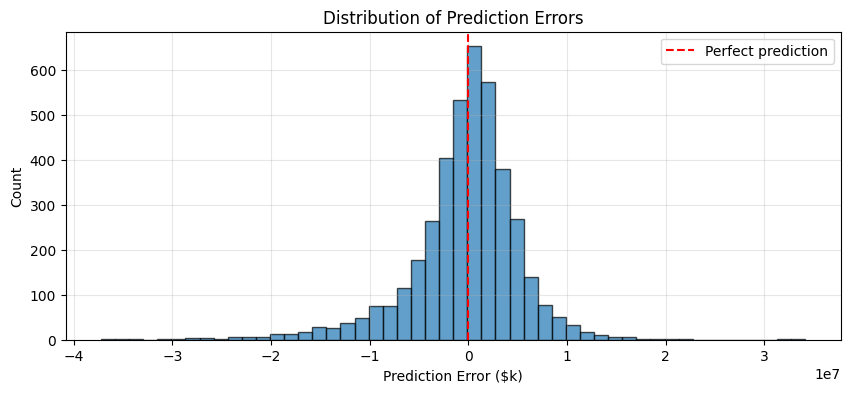

In [13]:
# Error distribution
print("Error Statistics (in $k):")
print(f"  Mean Error:   {results_df['Error_100k'].mean() * 100:+.2f}k")
print(f"  Std Error:    {results_df['Error_100k'].std() * 100:.2f}k")
print(f"  Median Error: {results_df['Abs_Error_100k'].median() * 100:.2f}k")
print(f"  Max Error:    {results_df['Abs_Error_100k'].max() * 100:.2f}k")

# Histogram of errors
plt.figure(figsize=(10, 4))
plt.hist(results_df['Error_100k'] * 100, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error ($k)')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='red', linestyle='--', label='Perfect prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [14]:
cudnn.destroy_handle(handle)